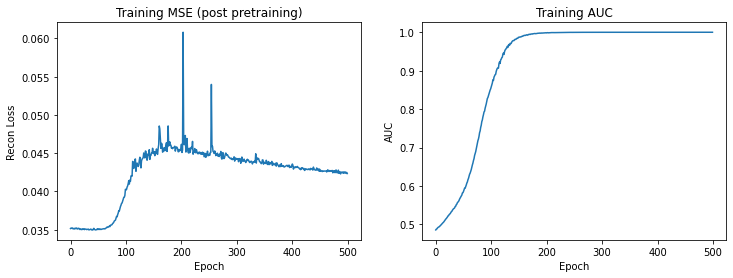

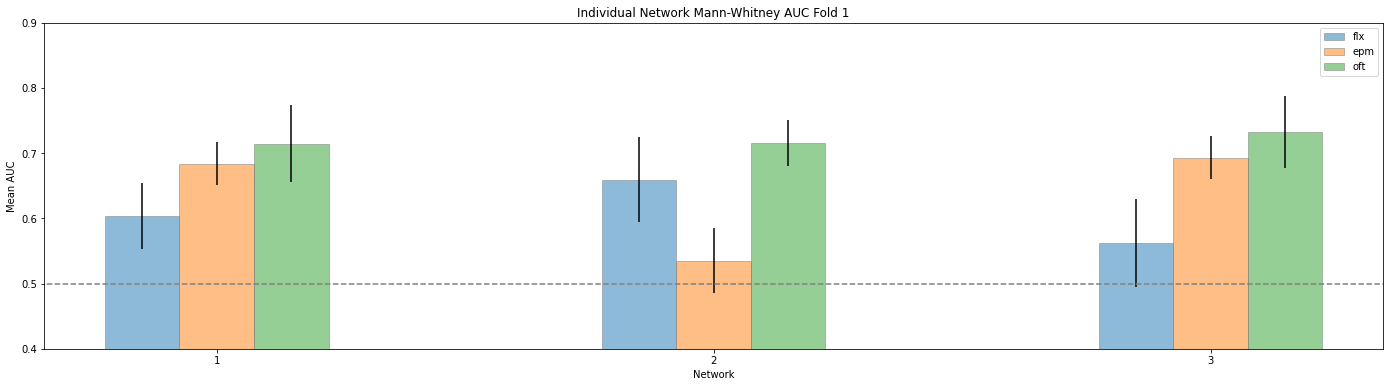

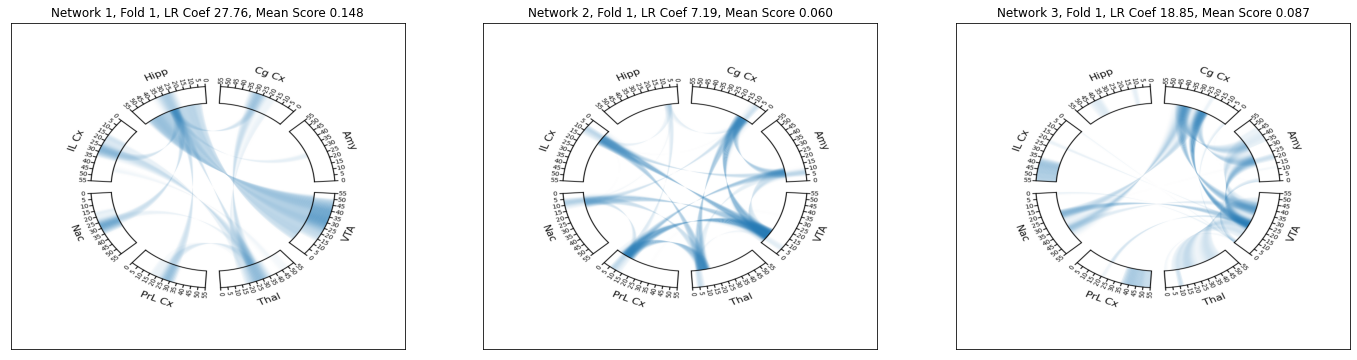

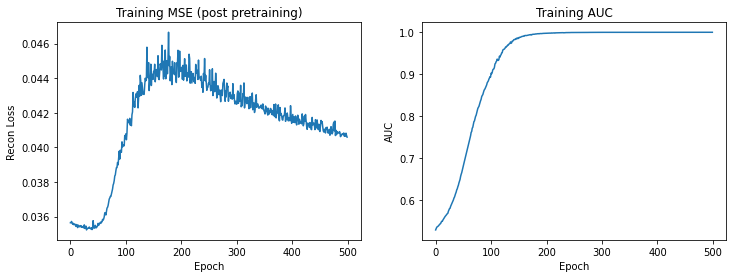

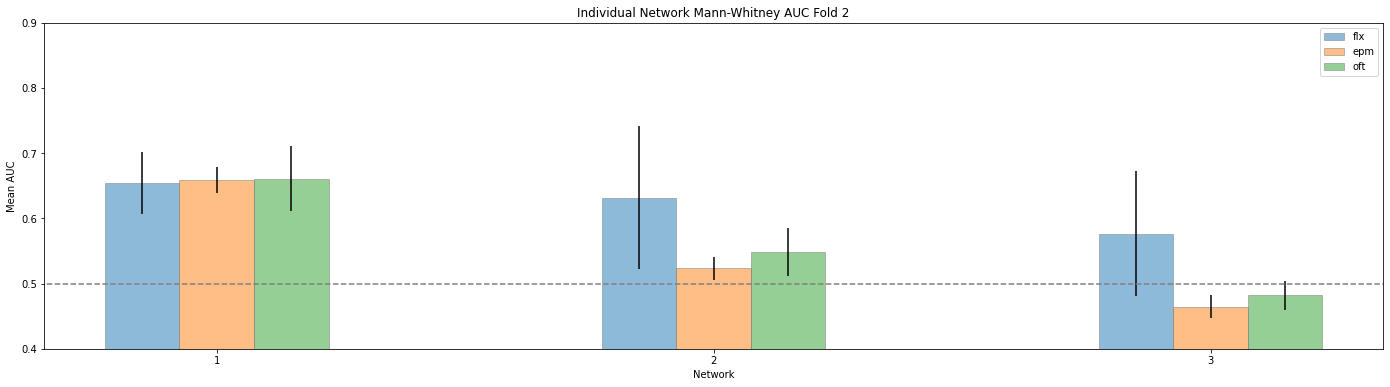

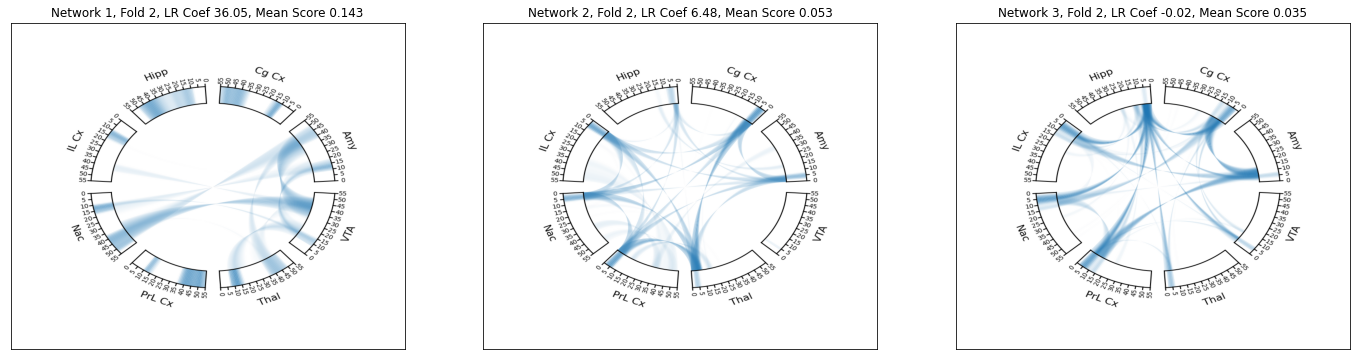

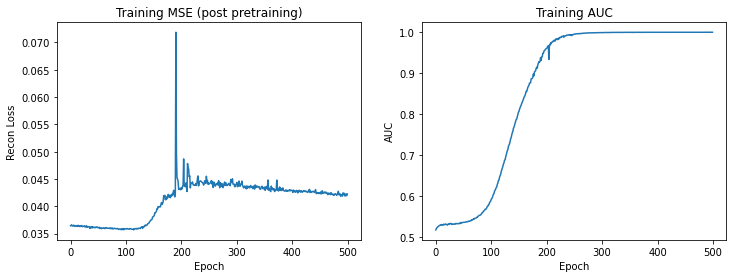

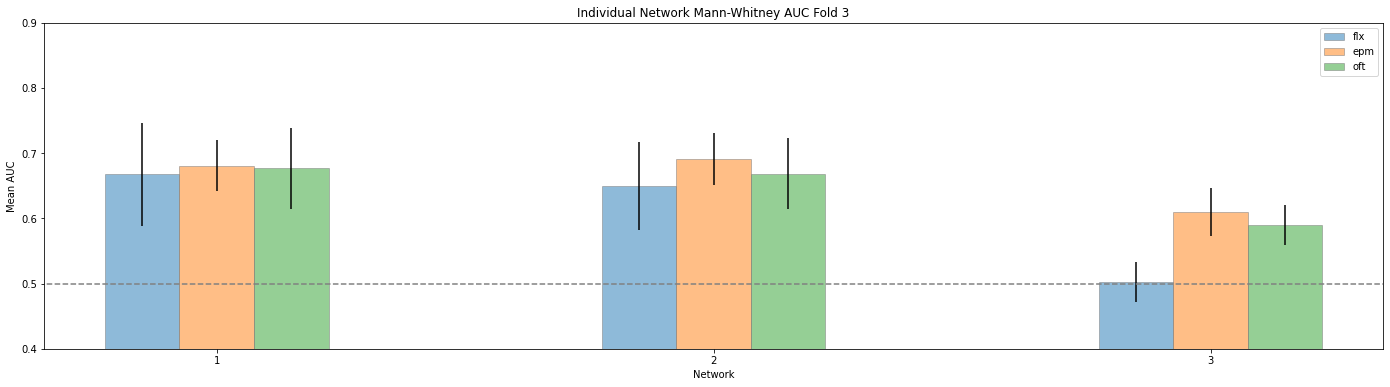

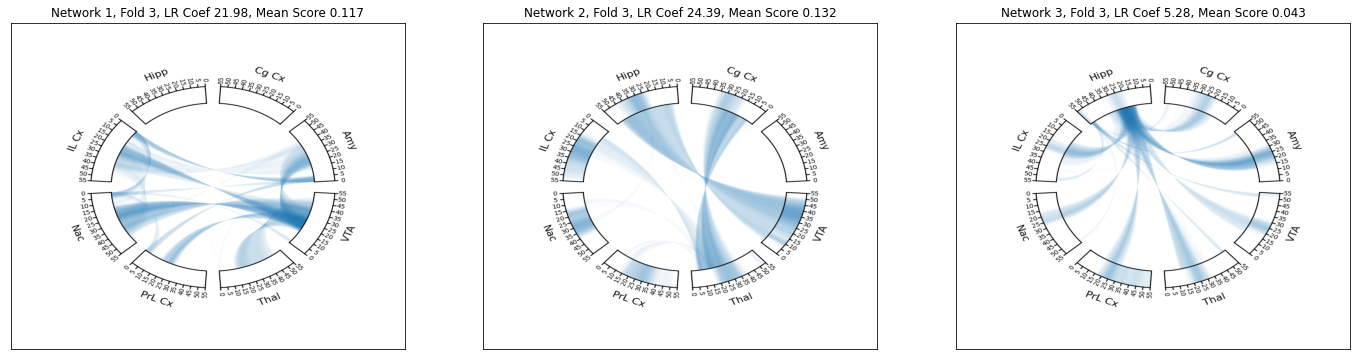

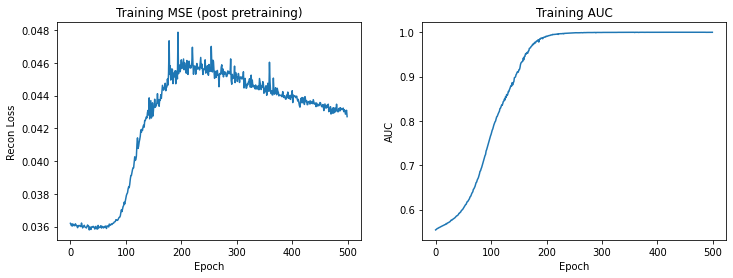

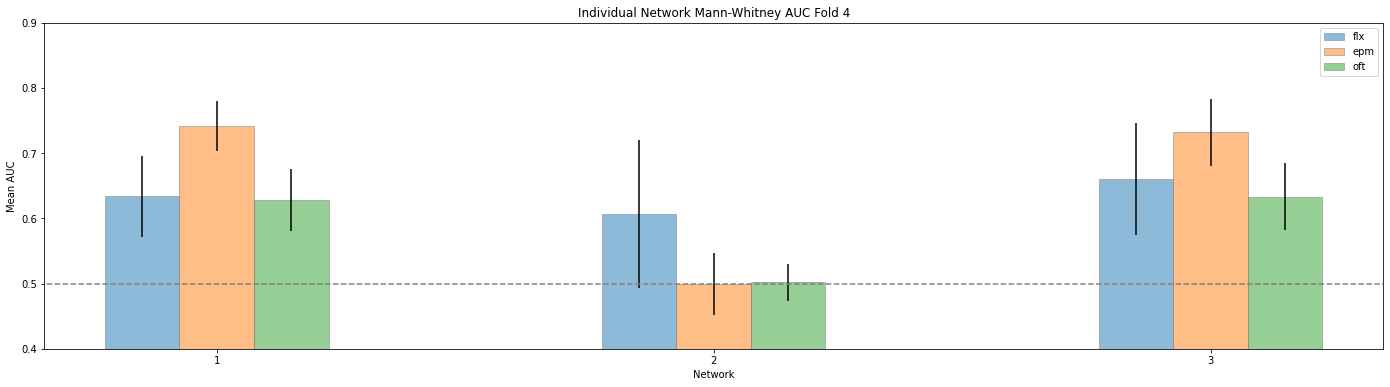

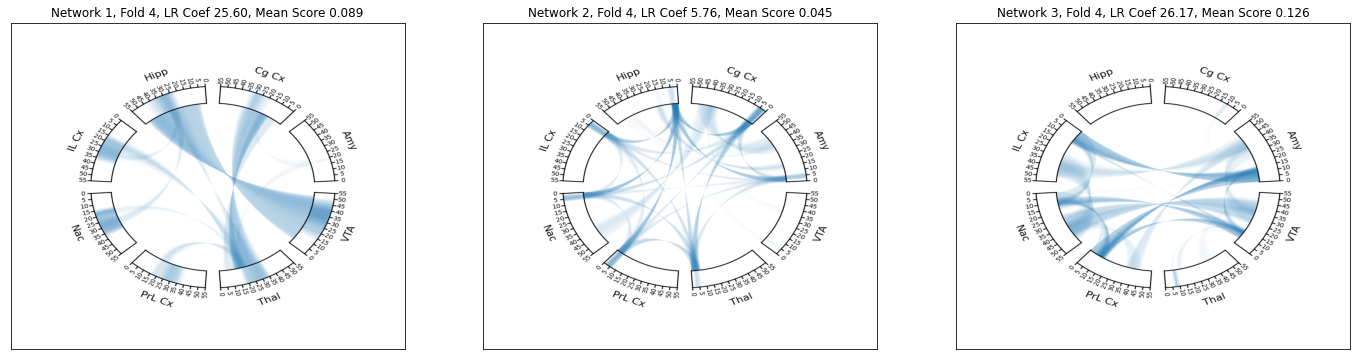

In [89]:
import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.image as image
import matplotlib.pyplot as plt
import os, sys

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

N_COMPONENTS=30

fold = 1#int(os.environ['SLURM_ARRAY_TASK_ID'])

for fold in [1,2,3,4]:
    flx_data_path = "/work/mk423/Anxiety/fixed_flx_kf_dict_fold_{}.pkl".format(fold)
    epm_data_path = "/work/mk423/Anxiety/fixed_epm_kf_dict_fold_{}.pkl".format(fold)
    oft_data_path = "/work/mk423/Anxiety/fixed_oft_kf_dict_fold_{}.pkl".format(fold)
    anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

    saved_model_path = "/work/mk423/Anxiety/kfold_models/"
    saved_model_name = "500_fixed_bootstrap_321_net_{}_model.pt".format(fold)

    projection_save_path = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
    plots_path = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
    

    def reshapeData(X_psd,X_coh,n_rois,n_freqs,pow_features,coh_features,areas):
        X_3d = np.zeros((n_rois,n_rois,n_freqs))

        for i in range(n_rois):
            X_3d[i,i,:] = X_psd[i*n_freqs:(i+1)*n_freqs]


        split_coh_features = np.array([feature.split(' ')[0] for feature in coh_features])
        #print(split_coh_features)
        unique_coh_features = np.unique(split_coh_features)
        for i in range(n_rois):
            for j in range(n_rois):
                if i != j:
                    area_1 = areas[i]
                    area_2 = areas[j]
                    temp_feature = area_1 + "-" + area_2
                    temp_feature_2 = area_2 + "-" + area_1
                    if temp_feature in unique_coh_features:
                        feature_mask = np.where(split_coh_features==temp_feature,True,False)
                        X_3d[i,j,:] = X_coh[feature_mask==1]
                        X_3d[j,i,:] = X_coh[feature_mask==1]

                    elif temp_feature_2 in unique_coh_features:
                        feature_mask = np.where(split_coh_features==temp_feature_2,1,0)
                        X_3d[i,j,:] = X_coh[feature_mask==1]
                        X_3d[j,i,:] = X_coh[feature_mask==1]

                    else:
                        print("temp_feature: {} not found".format(temp_feature))

        return X_3d

    with open(flx_data_path,"rb") as f:
        flx_dict = pickle.load(f)

    with open(epm_data_path,"rb") as f:
        epm_dict = pickle.load(f)

    with open(oft_data_path,"rb") as f:
        oft_dict = pickle.load(f)

    with open(anx_info_dict,"rb") as f:
        anxInfo = pickle.load(f)

    info_dict = anxInfo
    feature_groups = [(0,len(info_dict["powerFeatures"])),
                       (len(info_dict["powerFeatures"]),len(info_dict["powerFeatures"])+len(info_dict["cohFeatures"])),
                       (len(info_dict["powerFeatures"])+len(info_dict["cohFeatures"]),
                        len(info_dict["powerFeatures"])+len(info_dict["cohFeatures"])+len(info_dict["gcFeatures"]))]

    mt_X_train = np.vstack([flx_dict["X_train"],epm_dict["X_train"],oft_dict["X_train"]])
    mt_y_train = np.hstack([flx_dict["y_train"],epm_dict["y_train"],oft_dict["y_train"]]).reshape(-1,1)
    mt_y_train_2_net = np.hstack([mt_y_train,mt_y_train])
    mt_y_mouse_train = np.hstack([flx_dict["y_mouse_train"],epm_dict["y_mouse_train"],oft_dict["y_mouse_train"]])
    mt_y_exp_train = np.hstack([np.ones(flx_dict["X_train"].shape[0])*0,
                               np.ones(epm_dict["X_train"].shape[0]),
                               np.ones(oft_dict["X_train"].shape[0])*2])
    intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()
    sample_groups = OrdinalEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1))

    train_idxs = np.random.binomial(1,.7,size=mt_X_train.shape[0])
    val_idxs = 1 - train_idxs
    mt_X_val = np.vstack([flx_dict["X_val"],epm_dict["X_val"],oft_dict["X_val"]])
    mt_y_val = np.hstack([flx_dict["y_val"],epm_dict["y_val"],oft_dict["y_val"]]).reshape(-1,1)
    mt_y_val_2_net = np.hstack([mt_y_val,mt_y_val])
    mt_y_mouse_val = np.hstack([flx_dict["y_mouse_val"],epm_dict["y_mouse_val"],oft_dict["y_mouse_val"]])

    model = torch.load(saved_model_path + saved_model_name)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(model.recon_hist)
    plt.xlabel("Epoch")
    plt.ylabel("Recon Loss")
    plt.title("Training MSE (post pretraining)")
    
    plt.subplot(1,2,2)
    plt.plot(model.pred_hist)
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Training AUC")
    
    plt.show()
    s_val = model.project(mt_X_val)
    s_flx = model.project(flx_dict["X_val"])
    y_pred_flx = model.predict_proba(flx_dict["X_val"])

    s_epm = model.project(epm_dict["X_val"])
    y_pred_epm = model.predict_proba(epm_dict["X_val"])

    s_oft = model.project(oft_dict["X_val"])
    y_pred_oft = model.predict_proba(oft_dict["X_val"])

    flx_mean_list = []
    flx_sterr_list = []

    epm_mean_list = []
    epm_sterr_list = []

    oft_mean_list = []
    oft_sterr_list = []

    for i in range(3):
        flx_mean, flx_sterr=umc_dt.get_mean_std_err_auc(y_pred_flx,
                                                       flx_dict["y_val"],
                                                       flx_dict["y_mouse_val"],
                                                       z=s_flx[:,i].reshape(-1,1),
                                                       mannWhitneyU=True)
        flx_mean_list.append(flx_mean)
        flx_sterr_list.append(flx_sterr)
        epm_mean, epm_sterr=umc_dt.get_mean_std_err_auc(y_pred_epm,
                                                       epm_dict["y_val"],
                                                       epm_dict["y_mouse_val"],
                                                       z=s_epm[:,i].reshape(-1,1),
                                                       mannWhitneyU=True)
        epm_mean_list.append(epm_mean)
        epm_sterr_list.append(epm_sterr)
        oft_mean, oft_sterr=umc_dt.get_mean_std_err_auc(y_pred_oft,
                                                       oft_dict["y_val"],
                                                       oft_dict["y_mouse_val"],
                                                       z=s_oft[:,i].reshape(-1,1),
                                                       mannWhitneyU=True)
        oft_mean_list.append(oft_mean)
        oft_sterr_list.append(oft_sterr)


    barWidth = 0.15
    fig = plt.subplots(figsize=(24,6))

    br1 = np.arange(len(flx_mean_list))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    plt.bar(br1, flx_mean_list,yerr=flx_sterr_list, width = barWidth,
            edgecolor ='grey', label ='flx',alpha=0.5)
    plt.bar(br2, epm_mean_list,yerr=epm_sterr_list, width = barWidth,
            edgecolor ='grey', label ='epm',alpha=0.5)
    plt.bar(br3, oft_mean_list,yerr=oft_sterr_list, width = barWidth,
            edgecolor ='grey', label ='oft',alpha=0.5)

    plt.xticks([r + barWidth for r in range(len(flx_mean_list))],
            [1,2,3])
    plt.axhline(0.5,-1,6,linestyle="dashed",color="grey")
    plt.xlabel('Network', fontsize = 10)
    plt.ylabel('Mean AUC', fontsize = 10)
    plt.ylim(0.4,0.9)
    plt.legend()
    plt.title("Individual Network Mann-Whitney AUC Fold {}".format(fold))
    plt.show()
    
    plt.figure(figsize=(24,6))

    for i,net in enumerate([1,2,3]):
        plots_file = plots_path + "500_fixed_bootstrap_321_network_net_{}_30_component_kf_fold_{}_electome.png".format(net,fold)
        plt.subplot(1,3,i+1)
        im = image.imread(plots_file.format(net,fold))
        plt.imshow(im,aspect="auto")
        plt.title("Network {}, Fold {}, LR Coef {:.2f}, Mean Score {:.3f}".format(net,
                                                                              fold,
                                                                              model.classifier[0].weight[0][i].cpu().detach().numpy(),
                                                                             np.mean(s_val[:,i])))
        plt.xticks([])
        plt.yticks([])
    plt.show()